## PUI 2016 HOMEWORK 5, ASSIGNMENT 2
#### Ian Wright, iw453
#### October 2016

## GENDER INCOME GAP

you may know that it is estimated that women earn about 78% of men in the same job position. 
Can we test that on NYC income data? Can we turn that into a prediction: if you get hired at a certain stipend as a men, what should you expect to make as a woman? (or from the point of view of a job employer, perhaps not one with a very strong moral compass, what should I offer to a woman job candidate, given what I would offer a man for the same job?)




In [80]:
import numpy as np
import pylab as pl
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
plt.style.use('ggplot')
import statsmodels.formula.api as sm
%pylab inline

Populating the interactive namespace from numpy and matplotlib


the Census data on income
http://www.census.gov/hhes/www/cpstables/032015/perinc/pinc03_000.htm

I posted the relevant data on the class webpage here : http://cosmo.nyu.edu/~fb55/PUI2016/data

# 1. Create two python dictionaries to store your data. 

 the file name root is "pinc_" (common to all files)
+ 08_2  are male, 
+ 08_3 are female, 
+ _1_1 is all ethnicities
+ _1_4 is white
+ _1_6 is black
+ _1_8 is asian
+ _1_9 is hispanic
+ extension is .xls for all files
put together the link name from this info and load the data on your allmales and allfemales dictionaries

use 1 header row (figure out which one by looking at the output of my 
allfemales['all'].head() and .columns a couple of cells below)

In [2]:
allmales = {}
allfemales = {}
# get data (could probably do this more elegantly with urllib or requests APIs)
allmales['all'] = pd.read_excel('http://cosmo.nyu.edu/~fb55/PUI2016/data/pinc08_2_1_1.xls', header=9).dropna()
allmales['White'] = pd.read_excel('http://cosmo.nyu.edu/~fb55/PUI2016/data/pinc08_2_1_4.xls',header=9).dropna()
allmales['Black'] = pd.read_excel('http://cosmo.nyu.edu/~fb55/PUI2016/data/pinc08_2_1_6.xls',header=9).dropna()
allmales['Asian'] = pd.read_excel('http://cosmo.nyu.edu/~fb55/PUI2016/data/pinc08_2_1_8.xls',header=9).dropna()
allmales['Hispanic'] = pd.read_excel('http://cosmo.nyu.edu/~fb55/PUI2016/data/pinc08_2_1_9.xls',header=9).dropna()
allfemales['all'] = pd.read_excel('http://cosmo.nyu.edu/~fb55/PUI2016/data/pinc08_3_1_1.xls',header=9).dropna()
allfemales['White'] = pd.read_excel('http://cosmo.nyu.edu/~fb55/PUI2016/data/pinc08_3_1_4.xls',header=9).dropna()
allfemales['Black'] = pd.read_excel('http://cosmo.nyu.edu/~fb55/PUI2016/data/pinc08_3_1_6.xls',header=9).dropna()
allfemales['Asian'] = pd.read_excel('http://cosmo.nyu.edu/~fb55/PUI2016/data/pinc08_3_1_8.xls',header=9).dropna()
allfemales['Hispanic'] = pd.read_excel('http://cosmo.nyu.edu/~fb55/PUI2016/data/pinc08_3_1_9.xls',header=9).dropna()
print 'all loaded'

all loaded


In [3]:
# clean up each dataset before we concatenate and analyze them
genders = [allmales, allfemales]
for gender in genders:
    for group in gender:
        # set the row index
        gender[group].set_index('Characteristic', inplace=True, drop=True)

        # clean up messy column names
        gender[group].rename(columns = lambda x: x.replace('$', '').replace('\n', ''), inplace=True)

        # and drop the columns that contain 'unnamed'
        good_cols = [c for c in gender[group].columns if 'Unnamed' not in c]
        gender[group] = gender[group][good_cols]
        
        # remove non-real values from all columns!
        for column in gender[group].columns:
            gender[group][column] = pd.to_numeric(gender[group][column], errors='coerce')
   

In [4]:
# checking that column clean-up went well
allmales['all'].columns

Index([u'Total with Income', u'1 to 2,499 or loss', u'2,500 to 4,999',
       u'5,000 to 7,499', u'7,500 to 9,999', u'10,000 to 12,499',
       u'12,500 to 14,999', u'15,000 to 17,499', u'17,500 to 19,999',
       u'20,000 to 22,499', u'22,500 to 24,999', u'25,000 to 27,499',
       u'27,500 to 29,999', u'30,000 to 32,499', u'32,500 to 34,999',
       u'35,000 to 37,499', u'37,500 to 39,999', u'40,000 to 42,499',
       u'42,500 to 44,999', u'45,000 to 47,499', u'47,500 to 49,999',
       u'50,000 to 52,499', u'52,500 to 54,999', u'55,000 to 57,499',
       u'57,500 to 59,999', u'60,000 to 62,499', u'62,500 to 64,999',
       u'65,000 to 67,499', u'67,500 to 69,999', u'70,000 to 72,499',
       u'72,500 to 74,999', u'75,000 to 77,499', u'77,500 to 79,999',
       u'80,000 to 82,499', u'82,500 to 84,999', u'85,000 to 87,499',
       u'87,500 to 89,999', u'90,000 to 92,499', u'92,500 to 94,999',
       u'95,000 to 97,499', u'97,500 to 99,999', u'100,000 and over',
       u'Median income'

In [5]:
allmales['all'].head()

,Total with Income,"1 to 2,499 or loss","2,500 to 4,999","5,000 to 7,499","7,500 to 9,999","10,000 to 12,499","12,500 to 14,999","15,000 to 17,499","17,500 to 19,999","20,000 to 22,499",...,"85,000 to 87,499","87,500 to 89,999","90,000 to 92,499","92,500 to 94,999","95,000 to 97,499","97,500 to 99,999","100,000 and over",Median income,Mean income,Gini ratio
Characteristic,,,,,,,,,,,,,,,,,,,,,
....Total,108706.0,4407.0,2665.0,3200.0,4027.0,4418.0,3333.0,5027.0,3807.0,5409.0,...,1024.0,427.0,1092.0,513.0,626.0,457.0,12003.0,35228.0,50779.0,0.501
Earnings,83555.0,3217.0,2326.0,2560.0,1964.0,3118.0,1505.0,3451.0,1959.0,4108.0,...,910.0,280.0,1199.0,246.0,559.0,259.0,10113.0,39903.0,54086.0,0.489
..Wages and Salary,78263.0,2779.0,2184.0,2419.0,1780.0,2777.0,1365.0,3149.0,1847.0,3821.0,...,892.0,262.0,1148.0,244.0,540.0,257.0,9392.0,40298.0,54268.0,0.483
..Nonfarm Self-Employment,7014.0,1478.0,280.0,342.0,231.0,556.0,144.0,377.0,122.0,376.0,...,19.0,0.0,42.0,0.0,18.0,0.0,516.0,19557.0,34247.0,0.630
..Farm Self-Employment,1518.0,804.0,62.0,66.0,26.0,75.0,15.0,70.0,14.0,82.0,...,8.0,0.0,0.0,0.0,2.0,3.0,83.0,2359.0,20918.0,0.820


# Descriptive phase: 


In [6]:
# just run this cell to get an idea of the data
for k,v in allfemales.items():
    print("#####", k)
    print(v.describe())
for k,v in allmales.items():
    print("#####", k)
    print(v.describe())

('#####', 'Hispanic')
       Total with Income  1 to 2,499 or loss  2,500 to 4,999  5,000 to 7,499  \
count          46.000000           46.000000       46.000000       46.000000   
mean         1908.739130          274.282609      137.717391      154.043478   
std          3688.718088          568.547923      199.157298      259.111813   
min             1.000000            0.000000        0.000000        0.000000   
25%            49.000000            7.500000        6.750000        6.000000   
50%           332.000000           72.000000       41.000000       29.000000   
75%          1888.750000          268.500000      188.500000      162.750000   
max         14034.000000         2704.000000      783.000000     1009.000000   

       7,500 to 9,999  10,000 to 12,499  12,500 to 14,999  15,000 to 17,499  \
count       46.000000         46.000000         46.000000         46.000000   
mean       188.913043        175.173913        101.521739        111.608696   
std        321.94856

# 2. Exploratory phase

# now you can plot the dataframe values with a scatter plot 

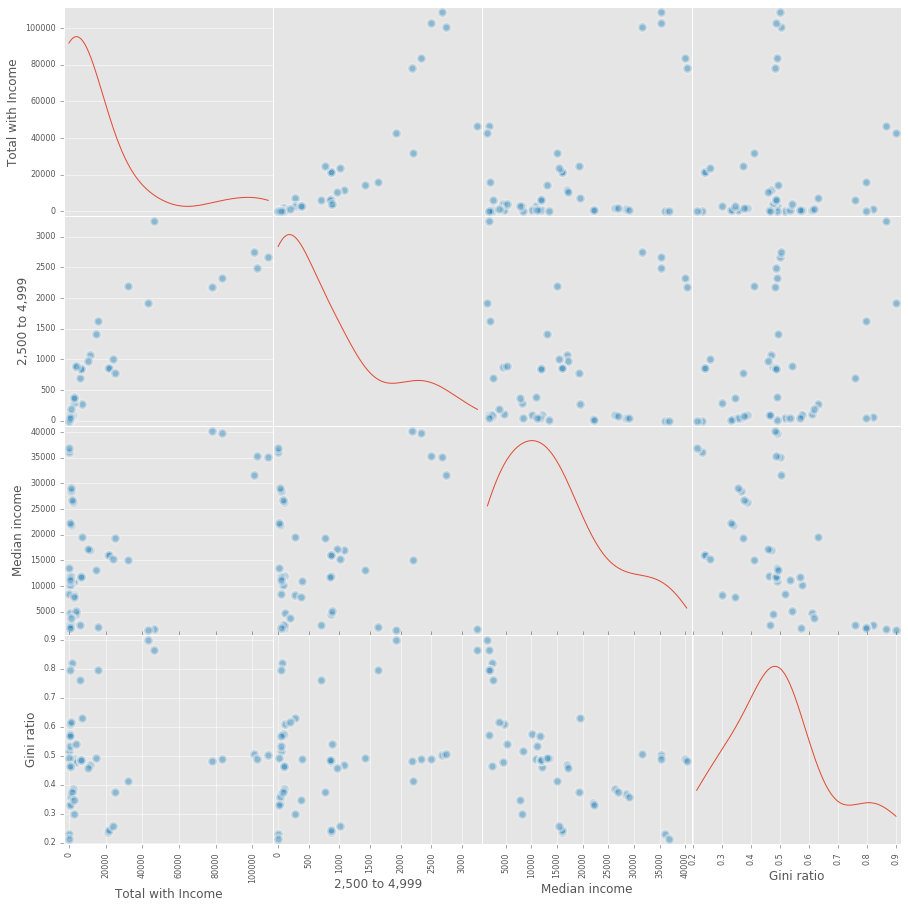

In [9]:
# plot a scatter matrix of 4 of the dimensions from male dataset
allmale_scatter = pd.scatter_matrix(allmales['all']
                   [[u'Total with Income', u'2,500 to 4,999', u'Median income', u'Gini ratio']],
                   linewidth=3, s=300, figsize=(15, 15), diagonal='kde')

#### Figure 1: Comparing total subset sample size, a count of individuals in low (2,500-4,999) income range, median income,= and the Gini ratio, across a wide selection of census income streams; male population only

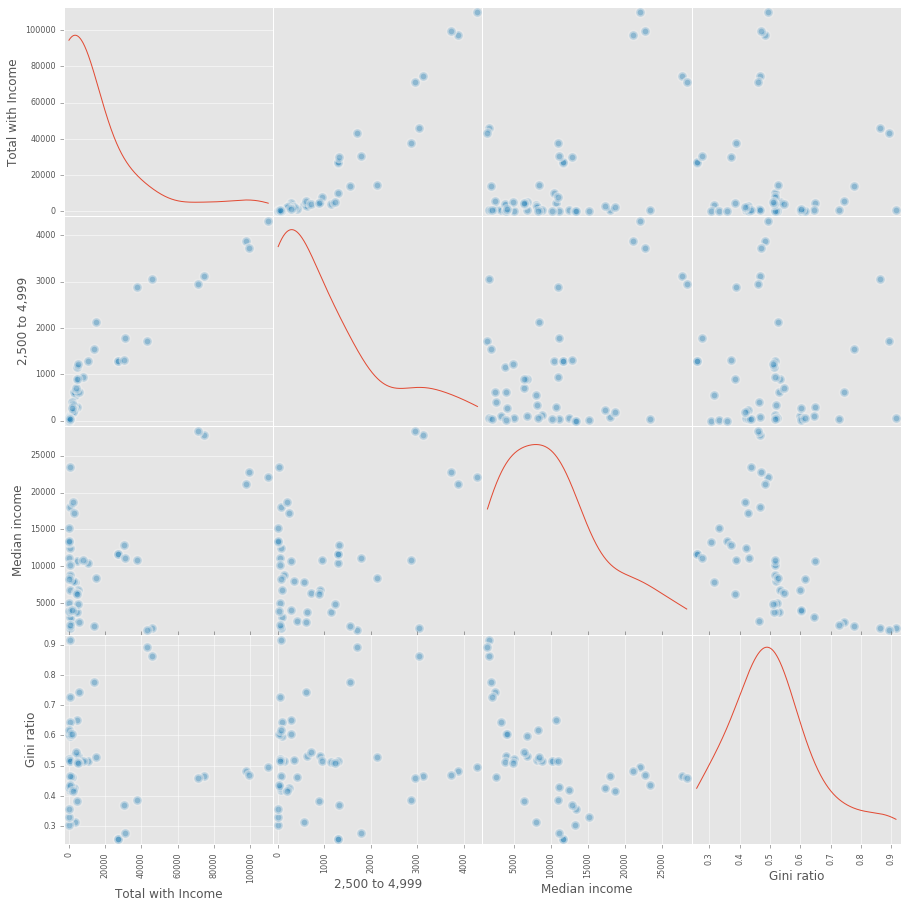

In [10]:
# plot a scatter matrix of 4 of the dimensions from female dataset
allfemale_scatter = pd.scatter_matrix(allfemales['all']
                   [[u'Total with Income', u'2,500 to 4,999', u'Median income', u'Gini ratio']],
                   linewidth=3, s=300, figsize=(15, 15), diagonal='kde')

#### Figure 2: Comparing total subset sample size, a count of individuals in low (2,500-4,999) income range, median income,= and the Gini ratio, across a wide selection of census income streams; female population only

## 3. to see how the male and female income relate to each other plot the Total Median Income (from any source of revenue) of females vs the Total Median Income of males, race by race (one data point per race)

#### also plot the 1-1 line: the diagonal that corresponds to men and women getting the same pay

           female     male
Hispanic  17762.0  25411.0
all       22063.0  35228.0
Black     20044.0  24855.0
White     23780.0  40122.0
Asian     24840.0  40153.0


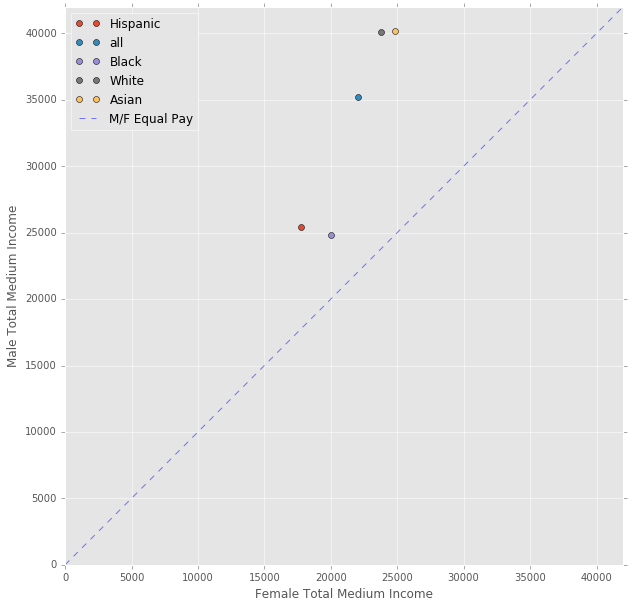

In [15]:
##plotting the Total median income by race

# extract total median income for each group
male_income = [data['Median income'][0] for group, data in allmales.iteritems()]
female_income = [data['Median income'][0] for group, data in allfemales.iteritems()]
income_index = [group for group, data in allfemales.iteritems()]

# built a dataframe
gender_compare = pd.DataFrame({'male':male_income, 'female':female_income}, index=income_index)
print gender_compare

fig, ax = plt.subplots()
fig.set_size_inches(10,10)

for index, row in gender_compare.iterrows():
    ax.plot(row['female'], row['male'], 'o', label=index)

ax.plot([0,42000], [0,42000], 'b--', alpha=0.5, label='M/F Equal Pay')
ax.set_xlabel('Female Total Medium Income')
ax.set_xlim([0,42000])
ax.set_ylabel('Male Total Medium Income')
ax.set_ylim([0,42000])
ax.legend(loc=2)
    
plt.show()

#### Figure 3: Comparing total median income between male and female samples and across various race groups

# 4. Now fit the data with a line.
### you can use statsmodels, or scipy, numpy, or create your own residual minimization function. 
### Below are steps on how to do this with numpy. Statsmodels requires fewer steps, and you are welcome to use that package. Numpy is less of a black box, so you would learn more taking yourself through the exercise. but you will be graded on the succesful fit, however you choose to perform it.

Steps to use numpy (and you do not have to!) you can for example use 

pl.plot(newx, np.poly1d(np.ployfit(x, y, 1))(newx)

to make and plot the fit in one line (although this way you did not save the parameters so you need to rerun the function to get the slope and intercept ... :-/

why not challenge yourself (if you want) and  create your own residual minimization function you can minimize it with scipy instead of a nested for loop (which is called 'brute force minimization')!

from scipy.optimize import minimize

def line ().....
    #this would be a function that creates a line given parameters, 
    #like we did in class
    ...
    return y

def residuals(data, model, error=None):
    #you can add errors if you want
    you want to return the sum of the residuals 
    #(difference b/w data and model **2)
    return residuals

You need an initial guess for the parameters, where you start searching. It has to be a single variable, so for 2 parameters (a and b for a line) you need to make make a list (or array or tuple) of 2 elements. The numbers inside do not have to be 0 and 1 like I have below - but choose something not too crazy or your minimization will get lost!

p0 = [0,1] 

then run: 

result = minimize(residuals, p0, args=(all_males, all_females))

in args I put all arguments of the function residuals that are not to be evaluated for the minimization (in this case the data)

In [17]:
print gender_compare

           female     male
Hispanic  17762.0  25411.0
all       22063.0  35228.0
Black     20044.0  24855.0
White     23780.0  40122.0
Asian     24840.0  40153.0


### I'm going to try the more "manual" method outlined above, along with the scipy minimization module:

#### A special note about a y-intercept in the regression model:
Upon visual inspection of the plotted points, it appears that the most accurate fitted line (for incomes that are sufficiently above zero), will have a negative intercept - that is, we will NOT force the line to pass through (0,0) yet.

In [34]:
# define a function to be the data model - for a simple line, the model should be of the form:
# male = b1*female + b0 --> just need to fit for the coefficients
def linear_model(female, coeffs): 
    return coeffs[1]*female + coeffs[0]

In [35]:
# define a function to calculate the sum of squared residuals (RSS) for any given iteration
# three args: 
# 1 - the current "guess" at best fitted coefficients
# 2 - the underlying model that we're trying to fit
# 3 - the dataset we're using
def residuals(coeff_approx, model, data):
    # get estimated y value for each x point in our dataset
    male_approx = data['female'].map(lambda x: model(x, coeff_approx))
    # compute RSS
    return (male_approx - data['male']).map(lambda diff: diff**2).sum()

In [36]:
# provide an initial guess for b0 and b1 parameters
b_guess = [0, 0]

In [41]:
# try to minimize using the scipy 'minimize' method
fit = minimize(residuals, b_guess, method = 'Nelder-Mead', args=(linear_model, gender_compare))
print fit

 final_simplex: (array([[ -2.11163004e+04,   2.50117986e+00],
       [ -2.11163004e+04,   2.50117986e+00],
       [ -2.11163003e+04,   2.50117986e+00]]), array([ 26926246.46268986,  26926246.46268989,  26926246.4626899 ]))
           fun: 26926246.462689858
       message: 'Optimization terminated successfully.'
          nfev: 285
           nit: 146
        status: 0
       success: True
             x: array([ -2.11163004e+04,   2.50117986e+00])


In [42]:
print 'intercept:', minimized.x[0]
print 'slope:', minimized.x[1]

intercept: -21116.3003639
slope: 2.50117985938


Model is of form: $male = 2.501*female - 21116$

## there is an analytical solution for the OLS (ordinary least square) regression which is coded below. please try to read the code and understand the formula! 


In [43]:
#this is the analytical best regression line. 
# it can be proved (ask me about it if you want!)
# run the cell below to get the beta0 and beta1 values
from scipy import stats

cor = stats.spearmanr(gender_compare['female'], gender_compare['male'])
beta1 = cor[0] * gender_compare['male'].std() / gender_compare['female'].std()
beta0 = gender_compare['male'].mean() - beta1 * gender_compare['female'].mean()
beta0, beta1

(-18816.688215839167, 2.3951962049534594)

## remake the scatter plot, with your line fit as well as the analytical solution to compare that with the result of your numerical one (remember: a line is y = beta0 + beta1 * x)

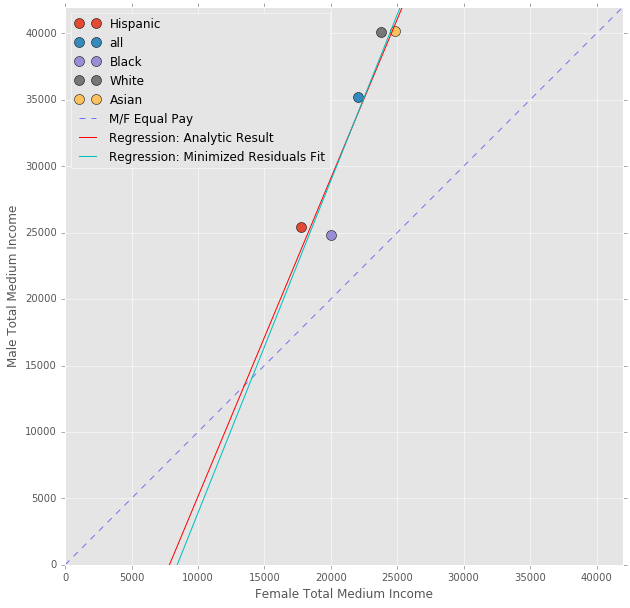

In [50]:
fig, ax = plt.subplots()
fig.set_size_inches(10,10)

# plot M-F comparison datapoints, by race
for index, row in gender_compare.iterrows():
    ax.plot(row['female'], row['male'], 'o', markersize=10, label=index)

ax.plot([0,42000], [0,42000], 'b--', alpha=0.5, label='M/F Equal Pay')

# plot both the RSS fitted line, and the analytical solution given by Spearmans
xlin = np.arange(0, 42000, 10)
ax.plot(xlin, beta0 + xlin*beta1, 'r-', label='Regression: Analytic Result')
ax.plot(xlin, minimized.x[0] + xlin*minimized.x[1], 'c-', label='Regression: Minimized Residuals Fit')

ax.set_xlabel('Female Total Medium Income')
ax.set_xlim([0,42000])
ax.set_ylabel('Male Total Medium Income')
ax.set_ylim([0,42000])
ax.legend(loc=2)
    
plt.show()

#### Figure 4: Total median income between male and female samples and across various race groups, plotted alongside the linear regression lines that describe the relationship between male and female incomes. Both an analytical solution and least-squares solution is provided.

# 5. this was done with THE TOTAL MEDIAN INCOME, let's now see if all forms of income lead to a different fit. 

In [71]:
#concatenate all male income datapoints into a single flat series
e_list = [allmales[group].loc[:, 'Median income'] for group, data in allmales.iteritems()]
all_male_income = [datapoint for series in all_male_list for datapoint in series]
print 'male datapoints:', shape(all_male_income)

#concatenate all female income datapoints into a single flat series
all_female_list = [allfemales[group].loc[:, 'Median income'] for group, data in allfemales.iteritems()]
all_female_income = [datapoint for series in all_female_list for datapoint in series]
print 'female datapoints:', shape(all_female_income)

# build a dataframe using the above two series
gender_compare_all = pd.DataFrame({'male':all_male_income, 'female':all_female_income})

male datapoints: (230,)
female datapoints: (230,)


Because we now have a lot of datapoints in a lower income range (and with some visual inspection), it makes sense to use a regression method that passes through (0,0).

In [73]:
# this time, we're going to fit all of these data points with a built-in function from statsmodel API
all_data_regression = sm.ols('male ~ female', data = gender_compare_all).fit()

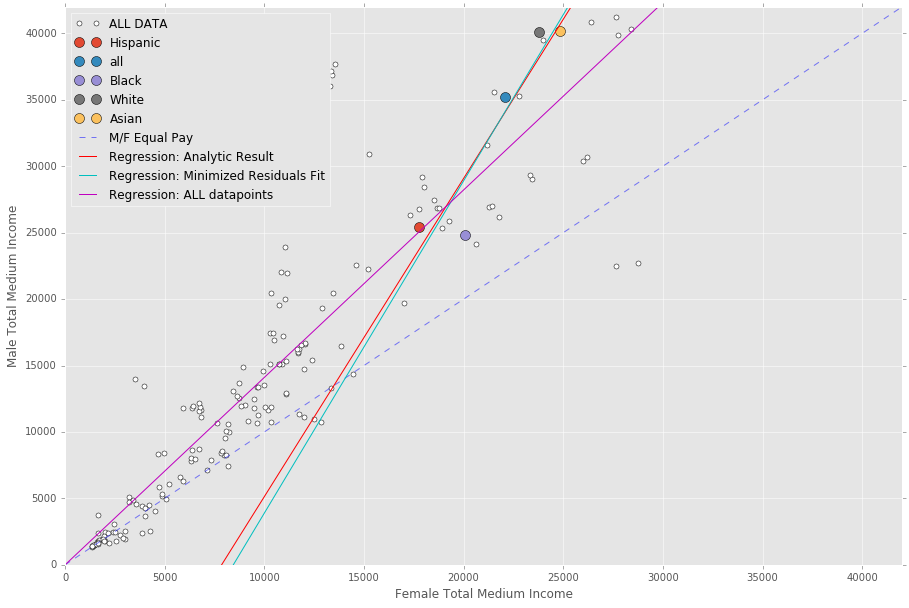

In [82]:
fig, ax = plt.subplots()
fig.set_size_inches(15,10)

# plot a small data point for every single M-F comparison in the dataset
ax.plot(gender_compare_all['female'], gender_compare_all['male'], 'wo', markersize=5, label='ALL DATA')

# plot M-F comparison datapoints, by race
for index, row in gender_compare.iterrows():
    ax.plot(row['female'], row['male'], 'o', markersize=10, label=index)

# plot the hypothetical equal-pay scenario
ax.plot([0,42000], [0,42000], 'b--', alpha=0.5, label='M/F Equal Pay')

# plot original RSS fitted line, the analytical solution given by Spearman, and finally the "all data" regression
xlin = np.arange(0, 42000, 10)

ax.plot(xlin, 
        beta0 + xlin*beta1, 
        'r-', label='Regression: Analytic Result')
ax.plot(xlin, 
        minimized.x[0] + xlin*minimized.x[1], 
        'c-', label='Regression: Minimized Residuals Fit')
ax.plot(xlin, 
        all_data_regression.params[0] + xlin*all_data_regression.params[1], 
        'm-', label='Regression: ALL datapoints')

ax.set_xlabel('Female Total Medium Income')
ax.set_xlim([0,42000])
ax.set_ylabel('Male Total Medium Income')
ax.set_ylim([0,42000])
ax.legend(loc=2)
    
plt.show()

#### Figure 5: Datasets for all male and female income of ALL races is concatenated and plotted alongside a corresponding regression line. The previous regression estimates using only 'Total Income' (both analytical and least-sqaures methods) are plotted as well.

+ It's interesting to see the difference between a regression that is forced through (0,0) and one that is not. When only the 'total income' for each race was plotted (male against female), it appeared that the regression line should clearly NOT pass through (0,0)... but when ALL datapoints were plotted, the story was different.
+ Fortunately, the regression that takes into account ALL data points is more closely approaching the ideal "1-1" scenario, although we're still a long ways off!

# 6. PREDICTION


## Now pick a stipend (maybe your ideal stipend).
## and predict what a woman in a position where a man recieves your ideal stipend would make



Because I plotted y = male and x = female, we'll use a female input to predict what the male equivalent is. For this, we'll use our latest regression estimate that took into account ALL datapoints.

In [79]:
#if a woman is making 60K...
woman_input = 60000
man_prediction = all_data_regression.params[0] + woman_input*all_data_regression.params[1]
print 'Man makes', round(man_prediction, 2)

Man makes 84655.77


# 7. lastly do you have any comments about what these data tell us about race? 

The relationships are quite clear! Gender aside, it's evident that racial inequality in income is  huge problem; black and hispanic workers are making 60-70% of what white and asian workers can expect to make. Interestingly, the gender gap in income becomes more and more prevelant with higher incomes - that is, white and asian males can expect to earn ~160% of what their female equals earn, while black and hispanic males can expect a more modest 25% premium over their female equals.